In [1]:
from FLAI import data
from FLAI import causal_graph
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Prepare Data

In [2]:
df = pd.read_pickle('../Data/adult.pickle')
df.head(5)

,race,sex,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,Age (decade)=>=70,Education Years=6,Education Years=7,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,label
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.shape

(48842, 19)

In [4]:
df.columns

Index(['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30',
       'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60',
       'Age (decade)=>=70', 'Education Years=6', 'Education Years=7',
       'Education Years=8', 'Education Years=9', 'Education Years=10',
       'Education Years=11', 'Education Years=12', 'Education Years=<6',
       'Education Years=>12', 'label'],
      dtype='object')

In [5]:
df['age'] = df.apply(lambda row: 0 if row['Age (decade)=10'] == 1 
                            else 1 if row['Age (decade)=20'] == 1 
                            else 2 if row['Age (decade)=30'] == 1
                            else 3 if row['Age (decade)=40'] == 1
                            else 4 if row['Age (decade)=50'] == 1
                            else 5 if row['Age (decade)=60'] == 1
                            else 6 if row['Age (decade)=>=70'] == 1
                            else None,axis = 1)
df['education'] = df.apply(lambda row: 0 if row['Education Years=<6'] == 1 
                                  else 1 if row['Education Years=6'] == 1 
                                  else 2 if row['Education Years=7'] == 1 
                                  else 3 if row['Education Years=8'] == 1 
                                  else 4 if row['Education Years=9'] == 1 
                                  else 5 if row['Education Years=10'] == 1 
                                  else 6 if row['Education Years=11'] == 1 
                                  else 7 if row['Education Years=12'] == 1
                                  else 8 if row['Education Years=>12'] == 1  
                                  else None,axis = 1)

In [6]:
df.label.unique()

array([0., 1.])

In [7]:
flai_dataset = data.Data(df[['sex', 'race', 'age','education' ,'label']], transform=True)


In [8]:
flai_dataset.data.head()

,sex,race,age,education,label
0,1.0,0.0,1.0,2.0,0.0
1,1.0,1.0,2.0,4.0,0.0
2,1.0,1.0,1.0,7.0,1.0
3,1.0,0.0,3.0,5.0,1.0
4,0.0,1.0,0.0,5.0,0.0


## Create Causal Graph

In [9]:
flai_graph = causal_graph.CausalGraph(flai_dataset, target = 'label')

[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).


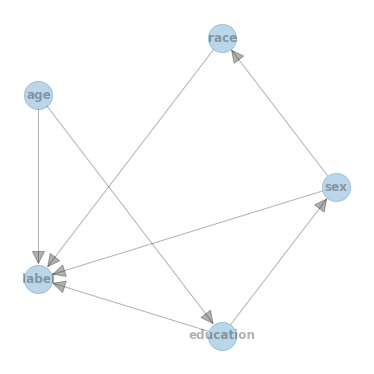

In [10]:
flai_graph.plot(directed = True)

In [11]:
flai_graph.calculate_cpd()

In [12]:
{n : list(np.round(flai_graph.inference(variables=[n], evidence={})['p']*100,2)) for n in flai_graph.graph['model'].nodes()}

{'sex': [33.15, 66.85],
 'race': [14.5, 85.5],
 'age': [5.14, 24.58, 26.47, 21.96, 13.55, 6.25, 2.05],
 'label': [76.57, 23.43],
 'education': [5.22, 2.84, 3.71, 1.35, 32.32, 22.27, 4.22, 3.28, 24.79]}

In [13]:
flai_graph.inference(variables=['sex','label'], evidence={})

,sex,label,p
0,0,0,0.292214
1,0,1,0.039304
2,1,0,0.473450
3,1,1,0.195032


In [14]:
flai_graph.inference(variables=['race','label'], evidence={})

,race,label,p
0,0,0,0.120734
1,0,1,0.024223
2,1,0,0.644930
3,1,1,0.210113


In [15]:

data_pred = flai_dataset.data[list(flai_graph.graph['model'].nodes())]
out = flai_graph.predict(data_pred, variables = ['label'])
flai_dataset.data['Predicted'] = out.label
flai_dataset.data['proba'] = abs(out.label -1 + out.p)

100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 467.20it/s]


In [16]:
result_metrics = flai_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0}})
result_metrics

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


{'model': {'ACC': 0.8044306129970108,
  'TN': 34716,
  'FP': 2439,
  'FN': 7113,
  'TP': 4574,
  'TPR': 0.3913750320869342,
  'FPR': 0.06564392410173597,
  'FNR': 0.6086249679130658,
  'PPP': 0.14358543876172147},
 'sex': {'privileged': {'ACC': 0.7616232771822359,
   'TN': 20293,
   'FP': 2439,
   'FN': 5344,
   'TP': 4574,
   'TPR': 0.46118168985682595,
   'FPR': 0.1072936829139539,
   'FNR': 0.538818310143174,
   'PPP': 0.21479326186830014},
  'unprivileged': {'ACC': 0.8907485177865613,
   'TN': 14423,
   'FP': 0,
   'FN': 1769,
   'TP': 0,
   'TPR': 0.0,
   'FPR': 0.0,
   'FNR': 1.0,
   'PPP': 0.0},
  'fair_metrics': {'EOD': -0.46118168985682595,
   'DI': 0.0,
   'SPD': -0.21479326186830014,
   'OD': -0.5684753727707799}},
 'race': {'privileged': {'ACC': 0.794502179014415,
   'TN': 28875,
   'FP': 2280,
   'FN': 6302,
   'TP': 4305,
   'TPR': 0.40586405204110493,
   'FPR': 0.0731824747231584,
   'FNR': 0.594135947958895,
   'PPP': 0.1576792299219386},
  'unprivileged': {'ACC': 0.862

In [17]:
df_performance,df_fairness = flai_dataset.get_df_metrics(metrics_json=result_metrics)

In [18]:
df_performance

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.804431,34716.0,2439.0,7113.0,4574.0,0.391375,0.065644,0.608625,0.143585
sex_privileged,0.761623,20293.0,2439.0,5344.0,4574.0,0.461182,0.107294,0.538818,0.214793
sex_unprivileged,0.890749,14423.0,0.0,1769.0,0.0,0.000000,0.000000,1.000000,0.000000
race_privileged,0.794502,28875.0,2280.0,6302.0,4305.0,0.405864,0.073182,0.594136,0.157679
race_unprivileged,0.862994,5841.0,159.0,811.0,269.0,0.249074,0.026500,0.750926,0.060452


In [19]:
df_fairness

,EOD,DI,SPD,OD
sex_fair_metrics,-0.461182,0.000000,-0.214793,-0.568475
race_fair_metrics,-0.156790,0.383386,-0.097227,-0.203472


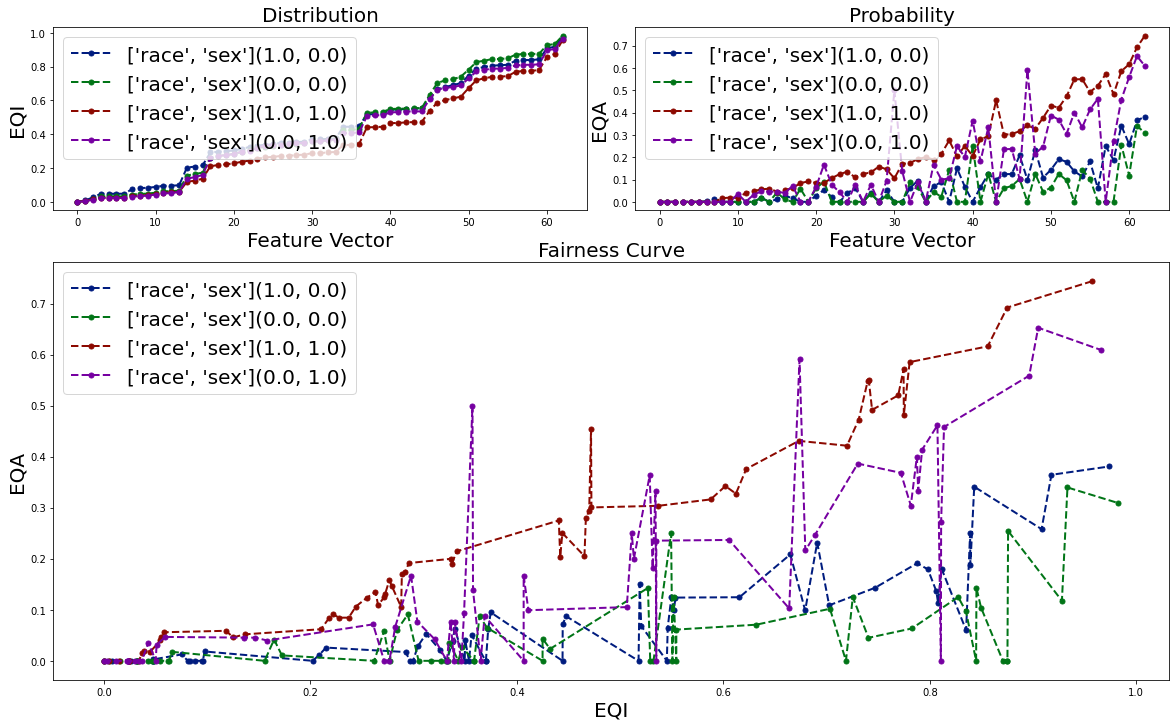

In [20]:
df_f,datos_f = flai_dataset.fairness_eqa_eqi(features = ['education','age'], 
                              target_column = 'proba', 
                              column_filter = ['race','sex'],
                              plot = True)

In [21]:
df_f

,group,reference,EQI,EQA,F
0,"['race', 'sex'](1.0, 0.0)","['race', 'sex'](1.0, 1.0)",-0.07,0.15,0.17
1,"['race', 'sex'](0.0, 0.0)","['race', 'sex'](1.0, 1.0)",-0.06,0.18,0.19
3,"['race', 'sex'](0.0, 1.0)","['race', 'sex'](1.0, 1.0)",-0.04,0.06,0.07


## Mitigate Causal Graph

In [22]:
flai_graph.mitigate_edge_relation(sensible_feature=['sex','race'])

[('sex', 'label'),
 ('race', 'label'),
 ('age', 'label'),
 ('age', 'education'),
 ('education', 'label'),
 ('sex', 'education'),
 ('race', 'education')]

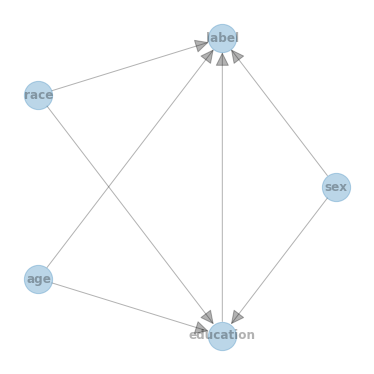

In [23]:
flai_graph.plot(directed = True)

In [43]:
flai_graph.mitigate_calculation_cpd(sensible_feature = ['sex','race'])


In [44]:
{n : list(np.round(flai_graph.inference(variables=[n], evidence={})['p']*100,2)) for n in flai_graph.graph['model'].nodes()}

{'sex': [50.0, 50.0],
 'label': [76.07, 23.93],
 'education': [5.22, 2.84, 3.71, 1.35, 32.32, 22.27, 4.22, 3.28, 24.79],
 'race': [50.0, 50.0],
 'age': [5.14, 24.58, 26.47, 21.96, 13.55, 6.25, 2.05]}

In [45]:
flai_graph.inference(variables=['sex','label'], evidence={})

,sex,label,p
0,0,0,0.380359
1,0,1,0.119641
2,1,0,0.380359
3,1,1,0.119641


In [46]:
flai_graph.inference(variables=['race','label'], evidence={})

,race,label,p
0,0,0,0.380359
1,0,1,0.119641
2,1,0,0.380359
3,1,1,0.119641


In [47]:
data_pred = flai_dataset.data[list(flai_graph.graph['model'].nodes())]
out = flai_graph.predict(data_pred, variables = ['label'])
flai_dataset.data['Predicted'] = out.label
flai_dataset.data['proba'] = abs(out.label -1 + out.p)

100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 879.08it/s]


In [48]:
result_metrics_mitigated = flai_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0}})
result_metrics_mitigated

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


{'model': {'ACC': 0.78770320625691,
  'TN': 34832,
  'FP': 2323,
  'FN': 8046,
  'TP': 3641,
  'TPR': 0.31154273979635494,
  'FPR': 0.0625218678508949,
  'FNR': 0.6884572602036451,
  'PPP': 0.1221080217845297},
 'sex': {'privileged': {'ACC': 0.7495558958652374,
   'TN': 21332,
   'FP': 1400,
   'FN': 6777,
   'TP': 3141,
   'TPR': 0.31669691470054445,
   'FPR': 0.06158718986450818,
   'FNR': 0.6833030852994555,
   'PPP': 0.1390811638591118},
  'unprivileged': {'ACC': 0.8646245059288538,
   'TN': 13500,
   'FP': 923,
   'FN': 1269,
   'TP': 500,
   'TPR': 0.2826455624646693,
   'FPR': 0.06399500797337586,
   'FNR': 0.7173544375353307,
   'PPP': 0.08788290513833992},
  'fair_metrics': {'EOD': -0.03405135223587513,
   'DI': 0.6318821521177711,
   'SPD': -0.05119825872077187,
   'OD': -0.031643534127007454}},
 'race': {'privileged': {'ACC': 0.7770461184809156,
   'TN': 29138,
   'FP': 2017,
   'FN': 7294,
   'TP': 3313,
   'TPR': 0.31234090694824174,
   'FPR': 0.06474081206868881,
   'FNR'

In [49]:
df_performance_mitigated,df_fairness_mitigated = flai_dataset.get_df_metrics(metrics_json=result_metrics_mitigated)

In [50]:
df_performance_mitigated

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.787703,34832.0,2323.0,8046.0,3641.0,0.311543,0.062522,0.688457,0.122108
sex_privileged,0.749556,21332.0,1400.0,6777.0,3141.0,0.316697,0.061587,0.683303,0.139081
sex_unprivileged,0.864625,13500.0,923.0,1269.0,500.0,0.282646,0.063995,0.717354,0.087883
race_privileged,0.777046,29138.0,2017.0,7294.0,3313.0,0.312341,0.064741,0.687659,0.127628
race_unprivileged,0.850565,5694.0,306.0,752.0,328.0,0.303704,0.051000,0.696296,0.089548


In [51]:
df_fairness_mitigated

,EOD,DI,SPD,OD
sex_fair_metrics,-0.034051,0.631882,-0.051198,-0.031644
race_fair_metrics,-0.008637,0.701633,-0.038080,-0.022378


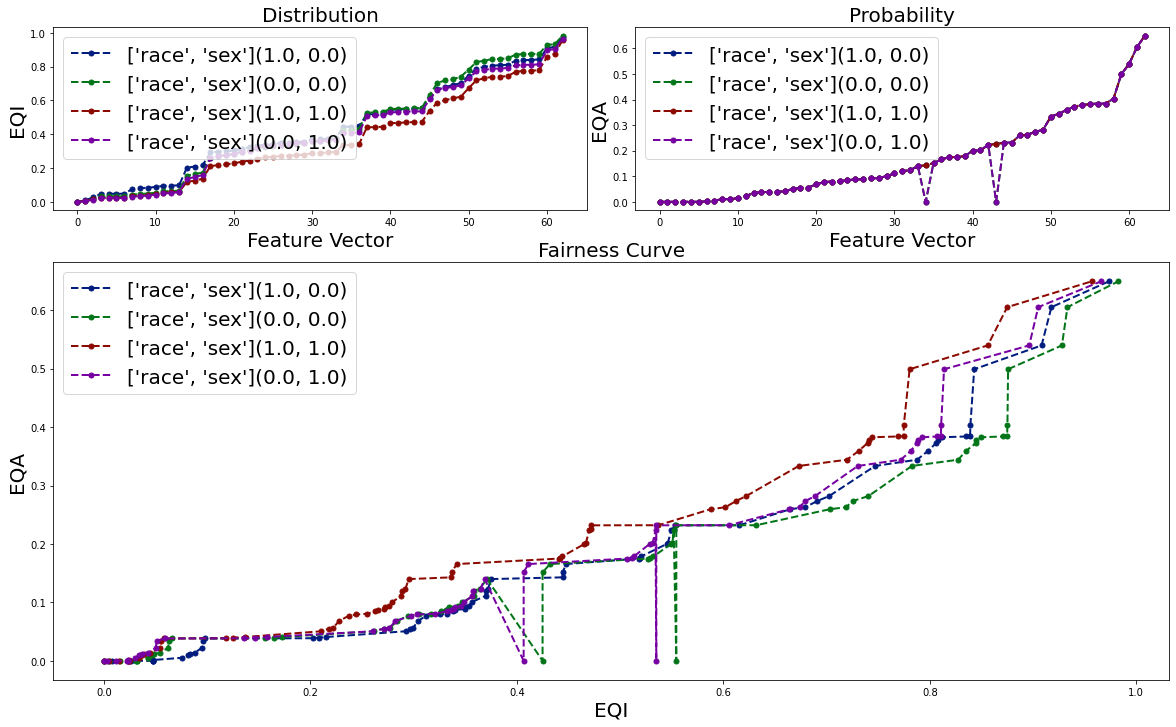

,group,reference,EQI,EQA,F
0,"['race', 'sex'](1.0, 0.0)","['race', 'sex'](1.0, 1.0)",-0.07,0.00,0.07
1,"['race', 'sex'](0.0, 0.0)","['race', 'sex'](1.0, 1.0)",-0.06,0.01,0.06
3,"['race', 'sex'](0.0, 1.0)","['race', 'sex'](1.0, 1.0)",-0.04,0.01,0.04


In [52]:
## Counterfactual equality fix, the problems comes from equity.
df_f,datos_f = flai_dataset.fairness_eqa_eqi(features = ['education','age'], 
                              target_column = 'proba', 
                              column_filter = ['race','sex'],
                              plot = True)
df_f

In [53]:
fair_data = flai_graph.generate_dataset(n_samples = 100*len(flai_dataset.data), methodtype = 'bayes')

                sex     label      race       age  education
sex        1.000000  0.214628  0.101034  0.087670   0.004188
label      0.214628  1.000000  0.083710  0.226896   0.319691
race       0.101034  0.083710  1.000000  0.030696   0.048834
age        0.087670  0.226896  0.030696  1.000000   0.029309
education  0.004188  0.319691  0.048834  0.029309   1.000000


<AxesSubplot: >

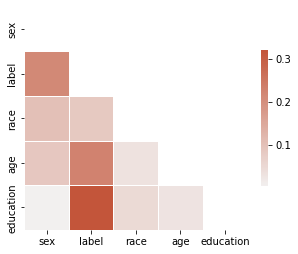

In [54]:
# Compute the correlation matrix
corr = flai_dataset.data[['sex','label','race','age','education']].corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

                sex     label  education      race       age
sex        1.000000 -0.000210  -0.000059 -0.000776 -0.000091
label     -0.000210  1.000000   0.320276 -0.000149  0.227146
education -0.000059  0.320276   1.000000 -0.000019  0.029036
race      -0.000776 -0.000149  -0.000019  1.000000  0.000543
age       -0.000091  0.227146   0.029036  0.000543  1.000000


<AxesSubplot: >

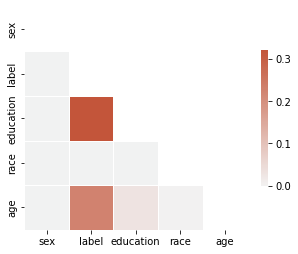

In [55]:
# Compute the correlation matrix
corr = fair_data.data.corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [56]:
data_pred = fair_data.data[list(flai_graph.graph['model'].nodes())]
out = flai_graph.predict(data_pred, variables = ['label'])
fair_data.data['Predicted'] = out.label
fair_data.data['proba'] = abs(out.label -1 + out.p)

100%|█████████████████████████████████████████████████████████████████████████████████| 252/252 [00:11<00:00, 22.14it/s]


In [57]:
result_metrics_mitigated_fair_data = fair_data.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0}})
result_metrics_mitigated_fair_data

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


{'model': {'ACC': 0.7877314606281479,
  'TN': 3482844,
  'FP': 231927,
  'FN': 804835,
  'TP': 364594,
  'TPR': 0.31177095830529256,
  'FPR': 0.06243372740876894,
  'FNR': 0.6882290416947074,
  'PPP': 0.12213279554481798},
 'sex': {'privileged': {'ACC': 0.7876801453036317,
   'TN': 1741704,
   'FP': 116078,
   'FN': 402478,
   'TP': 182074,
   'TPR': 0.31147613899191173,
   'FPR': 0.06248203502886776,
   'FNR': 0.6885238610080883,
   'PPP': 0.12207666928438125},
  'unprivileged': {'ACC': 0.7877827857875903,
   'TN': 1741140,
   'FP': 115849,
   'FN': 402357,
   'TP': 182520,
   'TPR': 0.3120656137957212,
   'FPR': 0.0623853991596073,
   'FNR': 0.6879343862042788,
   'PPP': 0.12218893256222906},
  'fair_metrics': {'EOD': 0.0005894748038094422,
   'DI': 1.0009196128834927,
   'SPD': 0.00011226327784780166,
   'OD': 0.0004928389345489823}},
 'race': {'privileged': {'ACC': 0.7876959773216153,
   'TN': 1741605,
   'FP': 116242,
   'FN': 402311,
   'TP': 182344,
   'TPR': 0.3118830763441688,

In [58]:
df_performance_mitigated_fair_data, df_fairness_mitigated_fair_data = fair_data.get_df_metrics(result_metrics_mitigated_fair_data)

In [59]:
df_performance_mitigated_fair_data

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.787731,3482844.0,231927.0,804835.0,364594.0,0.311771,0.062434,0.688229,0.122133
sex_privileged,0.787680,1741704.0,116078.0,402478.0,182074.0,0.311476,0.062482,0.688524,0.122077
sex_unprivileged,0.787783,1741140.0,115849.0,402357.0,182520.0,0.312066,0.062385,0.687934,0.122189
race_privileged,0.787696,1741605.0,116242.0,402311.0,182344.0,0.311883,0.062568,0.688117,0.122246
race_unprivileged,0.787767,1741239.0,115685.0,402524.0,182250.0,0.311659,0.062299,0.688341,0.122020


In [60]:
df_fairness_mitigated_fair_data

,EOD,DI,SPD,OD
sex_fair_metrics,0.000589,1.000920,0.000112,0.000493
race_fair_metrics,-0.000224,0.998148,-0.000226,-0.000493


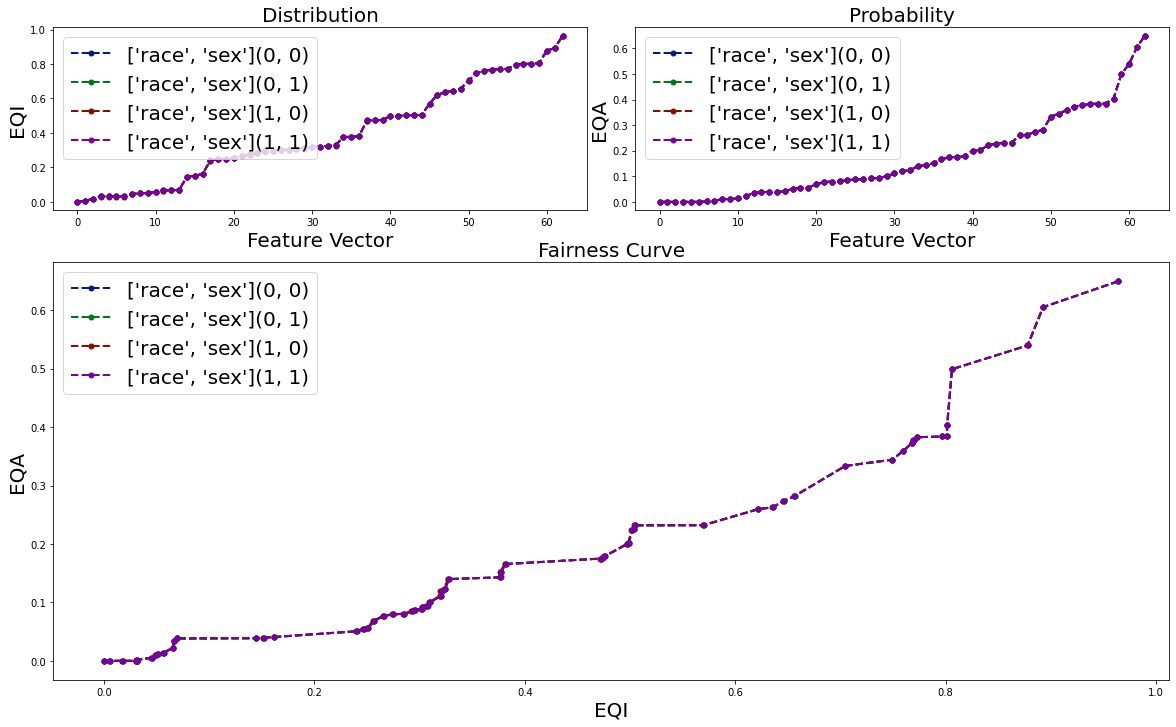

,group,reference,EQI,EQA,F
0,"['race', 'sex'](0, 0)","['race', 'sex'](1, 1)",0.0,-0.0,0.0
1,"['race', 'sex'](0, 1)","['race', 'sex'](1, 1)",0.0,0.0,0.0
2,"['race', 'sex'](1, 0)","['race', 'sex'](1, 1)",0.0,0.0,0.0


In [61]:
df_f,datos_f = fair_data.fairness_eqa_eqi(features = ['education','age'], 
                              target_column = 'proba', 
                              column_filter = ['race','sex'],
                              plot = True)
df_f

## Train Algorithm

In [50]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [51]:
original_X = flai_dataset.data[['sex', 'race', 'age','education']]
original_y = flai_dataset.data[['label']]
mitigated_X = fair_data.data[['sex', 'race', 'age','education']]
mitigated_y = fair_data.data[['label']]


In [52]:
original_X_train, original_X_test, original_y_train, original_y_test = train_test_split(original_X, original_y, test_size=0.5, random_state=54)
mitigated_X_train, mitigated_X_test, mitigated_y_train, mitigated_y_test = train_test_split(mitigated_X, mitigated_y, test_size=0.5, random_state=54)


In [53]:
model_original = XGBClassifier()
model_original.fit(original_X_train, original_y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [54]:
model_mitigated = XGBClassifier()
model_mitigated.fit(mitigated_X_train, mitigated_y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [66]:
original_y_test['Predicted'] = model_original.predict(original_X_test[['sex','race','age','education']])
original_y_test['proba'] = model_original.predict_proba(original_X_test[['sex','race','age','education']])[:,1]
mitigated_y_test['Predicted'] = model_mitigated.predict(mitigated_X_test[['sex','race','age','education']])
mitigated_y_test['proba'] = model_mitigated.predict_proba(mitigated_X_test[['sex','race','age','education']])[:,1]

In [67]:
original_X_test[['label', 'Predicted','proba']] = original_y_test[['label', 'Predicted','proba']]
mitigated_X_test[['label', 'Predicted','proba']] = mitigated_y_test[['label', 'Predicted','proba']]


In [68]:
original_dataset = data.Data(original_X_test, transform=False)
mitigated_dataset = data.Data(mitigated_X_test, transform=False)

In [69]:
metrics_xgboost_original = original_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                           'race' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_xgboost,df_fairness_xgboost = original_dataset.get_df_metrics(metrics_xgboost_original)

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


In [70]:
df_performance_xgboost

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.804021,17210.0,1386.0,3400.0,2425.0,0.416309,0.074532,0.583691,0.156054
sex_privileged,0.760823,10035.0,1386.0,2531.0,2425.0,0.489306,0.121355,0.510694,0.232704
sex_unprivileged,0.891969,7175.0,0.0,869.0,0.0,0.000000,0.000000,1.000000,0.000000
race_privileged,0.794092,14338.0,1315.0,3000.0,2303.0,0.434282,0.084009,0.565718,0.172647
race_unprivileged,0.864069,2872.0,71.0,400.0,122.0,0.233716,0.024125,0.766284,0.055700


In [71]:
df_fairness_xgboost

,EOD,DI,SPD,OD
sex_fair_metrics,-0.489306,0.000000,-0.232704,-0.610661
race_fair_metrics,-0.200566,0.322622,-0.116948,-0.260450


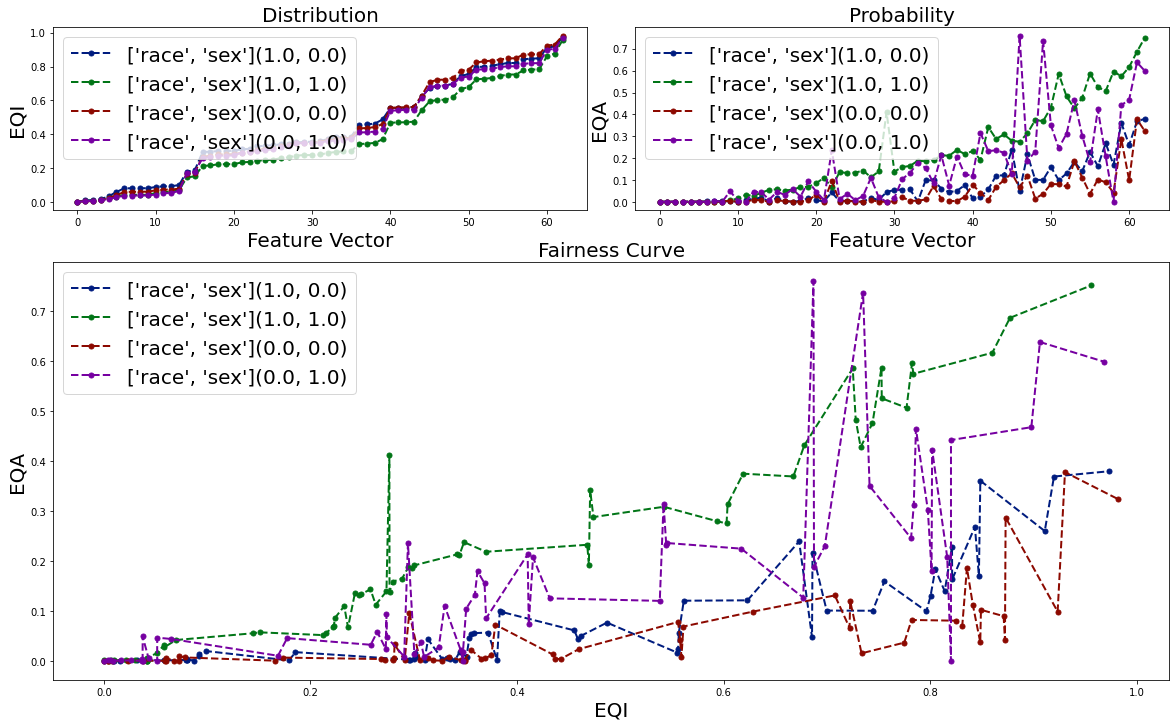

,group,reference,EQI,EQA,F
0,"['race', 'sex'](1.0, 0.0)","['race', 'sex'](0.0, 1.0)",-0.02,0.08,0.08
1,"['race', 'sex'](1.0, 1.0)","['race', 'sex'](0.0, 1.0)",0.04,-0.06,0.07
2,"['race', 'sex'](0.0, 0.0)","['race', 'sex'](0.0, 1.0)",-0.02,0.11,0.11


In [72]:
df_f,datos_f = original_dataset.fairness_eqa_eqi(features = ['education','age'], 
                              target_column = 'proba', 
                              column_filter = ['race','sex'],
                              plot = True)
df_f

In [73]:
metrics_xgboost_mitigated_fair_data = mitigated_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_xgboost_mitigated_fair_data,df_fairness_xgboost_mitigated_fair_data = original_dataset.get_df_metrics(metrics_xgboost_mitigated_fair_data)

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


In [74]:
df_performance_xgboost_mitigated_fair_data

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.787650,1741560.0,116464.0,402115.0,181961.0,0.311537,0.062682,0.688463,0.122200
sex_privileged,0.787339,870358.0,58343.0,201311.0,90963.0,0.311225,0.062822,0.688775,0.122284
sex_unprivileged,0.787962,871202.0,58121.0,200804.0,90998.0,0.311848,0.062541,0.688152,0.122116
race_privileged,0.787627,871636.0,58423.0,201013.0,90534.0,0.310530,0.062816,0.689470,0.121935
race_unprivileged,0.787674,869924.0,58041.0,201102.0,91427.0,0.312540,0.062547,0.687460,0.122465


In [75]:
df_fairness_xgboost_mitigated_fair_data

,EOD,DI,SPD,OD
sex_fair_metrics,0.000623,0.998625,-0.000168,0.000342
race_fair_metrics,0.002010,1.004345,0.000530,0.001740


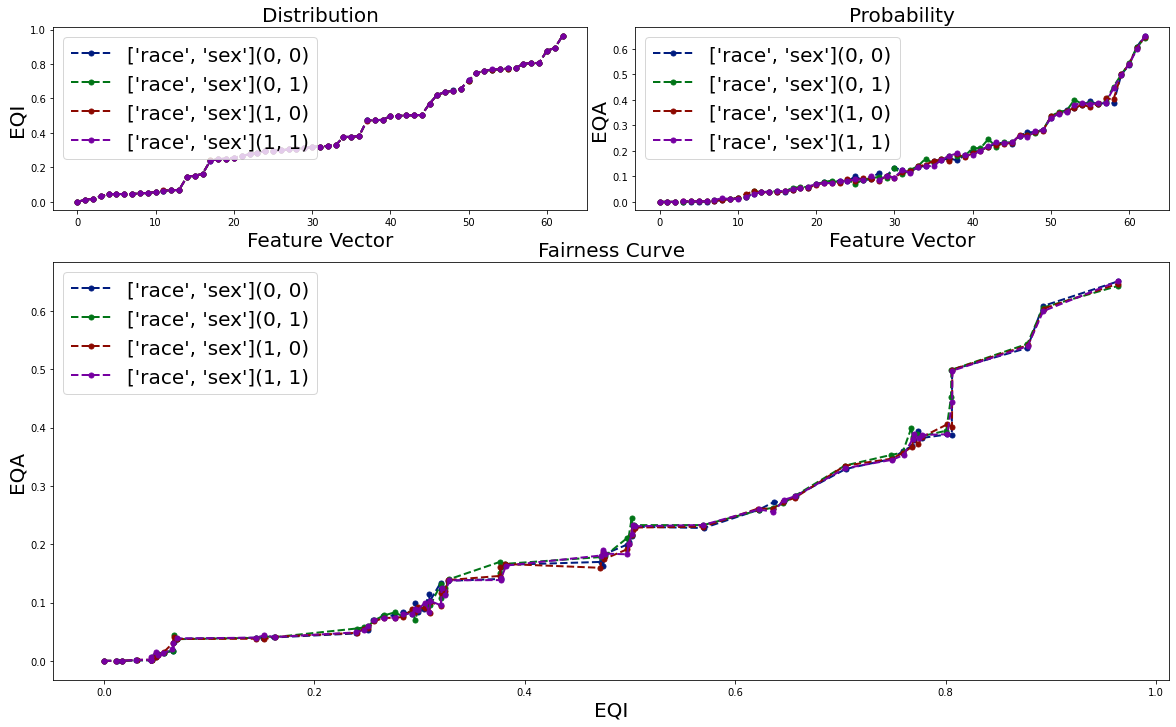

,group,reference,EQI,EQA,F
0,"['race', 'sex'](0, 0)","['race', 'sex'](1, 1)",0.0,0.0,0.0
1,"['race', 'sex'](0, 1)","['race', 'sex'](1, 1)",0.0,-0.0,0.0
2,"['race', 'sex'](1, 0)","['race', 'sex'](1, 1)",0.0,0.0,0.0


In [76]:
df_f,datos_f = mitigated_dataset.fairness_eqa_eqi(features = ['education','age'], 
                              target_column = 'proba', 
                              column_filter = ['race','sex'],
                              plot = True)
df_f

In [79]:
original_y['Predicted'] = model_mitigated.predict(original_X[['sex', 'race', 'age','education']])
original_y['proba'] = model_mitigated.predict_proba(original_X[['sex', 'race', 'age','education']])[:,1]
original_X[['label', 'Predicted','proba']] = original_y[['label', 'Predicted','proba']]
original_dataset = data.Data(original_X, transform=False)
metrics_xgboost_original = original_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                           'race' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_xgboost,df_fairness_xgboost = original_dataset.get_df_metrics(metrics_xgboost_original)
df_fairness_xgboost


Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


,EOD,DI,SPD,OD
sex_fair_metrics,-0.034051,0.631882,-0.051198,-0.031644
race_fair_metrics,-0.008637,0.701633,-0.038080,-0.022378


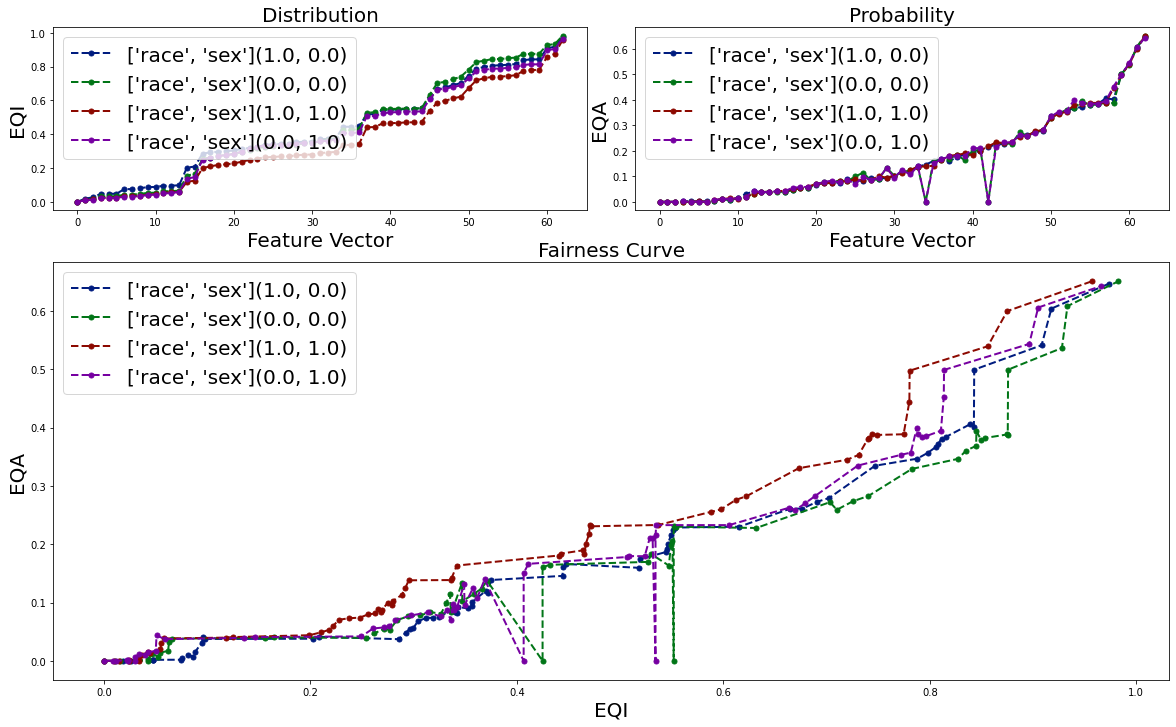

,group,reference,EQI,EQA,F
0,"['race', 'sex'](1.0, 0.0)","['race', 'sex'](1.0, 1.0)",-0.07,0.00,0.07
1,"['race', 'sex'](0.0, 0.0)","['race', 'sex'](1.0, 1.0)",-0.06,0.01,0.06
3,"['race', 'sex'](0.0, 1.0)","['race', 'sex'](1.0, 1.0)",-0.04,0.00,0.04


In [80]:
df_f,datos_f = original_dataset.fairness_eqa_eqi(features = ['education','age'], 
                              target_column = 'proba', 
                              column_filter = ['race','sex'],
                              plot = True)
df_f

### Explain Results

In [53]:
import shap

In [54]:
explainer_original = shap.Explainer(model_original)
explainer_mitigated = shap.Explainer(model_mitigated)

In [55]:
shap_values_orignal = explainer_original(original_dataset.data[['sex', 'race','age','education']])
shap_values_mitigated = explainer_mitigated(original_dataset.data[['sex', 'race', 'age','education']])

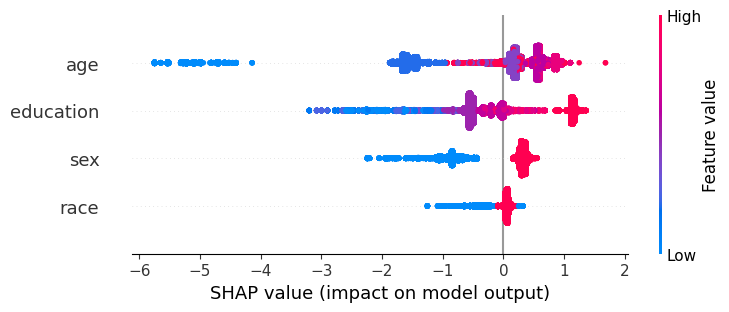

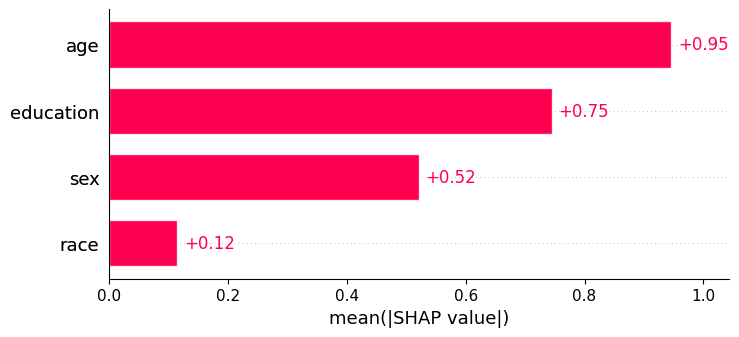

In [56]:
shap.plots.beeswarm(shap_values_orignal)
shap.plots.bar(shap_values_orignal)

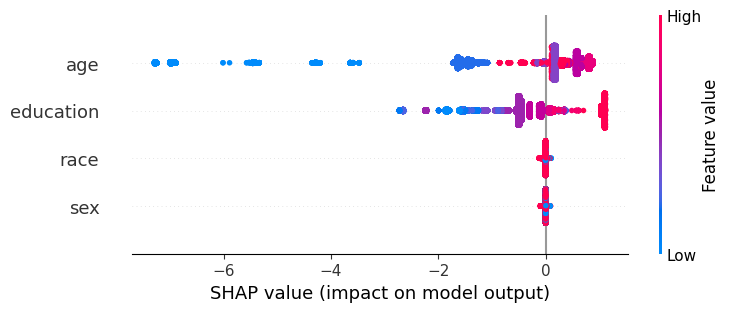

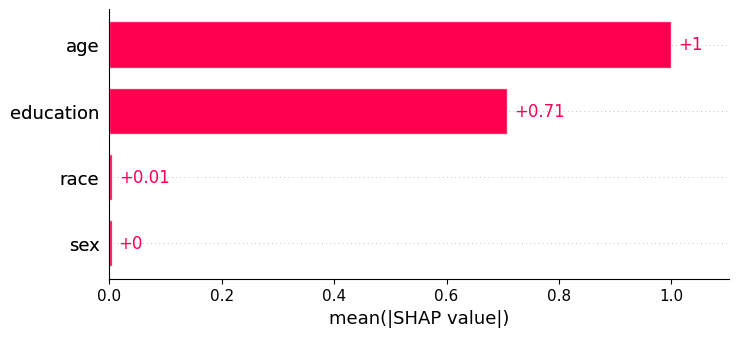

In [57]:
shap.plots.beeswarm(shap_values_mitigated)
shap.plots.bar(shap_values_mitigated)

In [58]:
shap_values_model_mitigated_dataset = explainer_original(mitigated_dataset.data[['sex', 'race', 'age','education']])
shap_values_mitigated_dataset = explainer_mitigated(mitigated_dataset.data[['sex', 'race', 'age','education']])

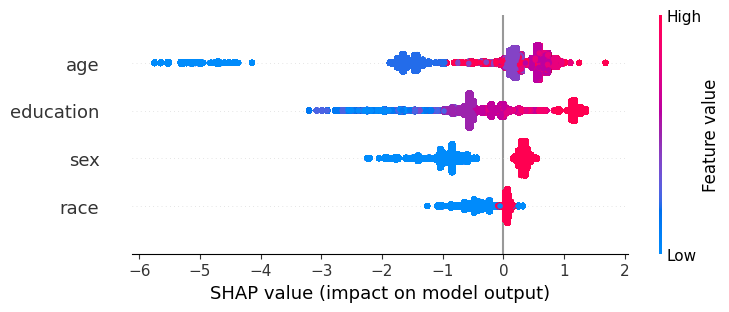

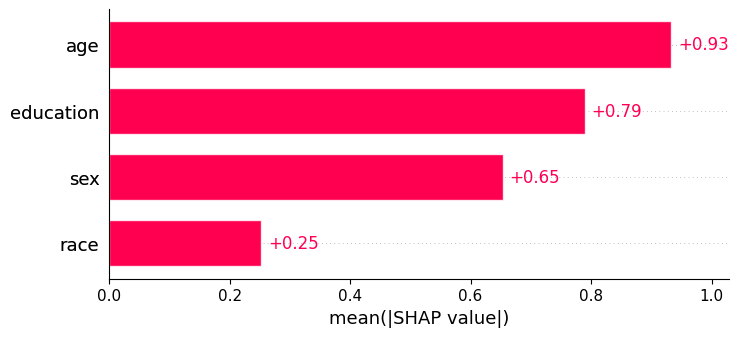

In [59]:
shap.plots.beeswarm(shap_values_model_mitigated_dataset)
shap.plots.bar(shap_values_model_mitigated_dataset)

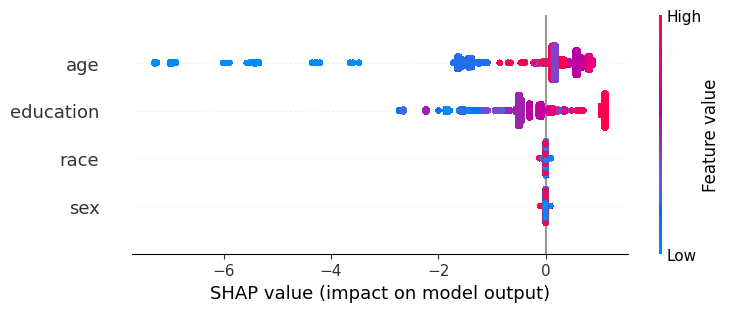

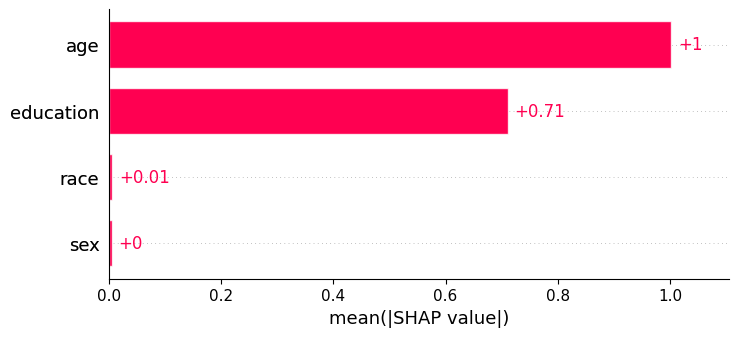

In [60]:
shap.plots.beeswarm(shap_values_mitigated_dataset)
shap.plots.bar(shap_values_mitigated_dataset)

### Test other algorithm

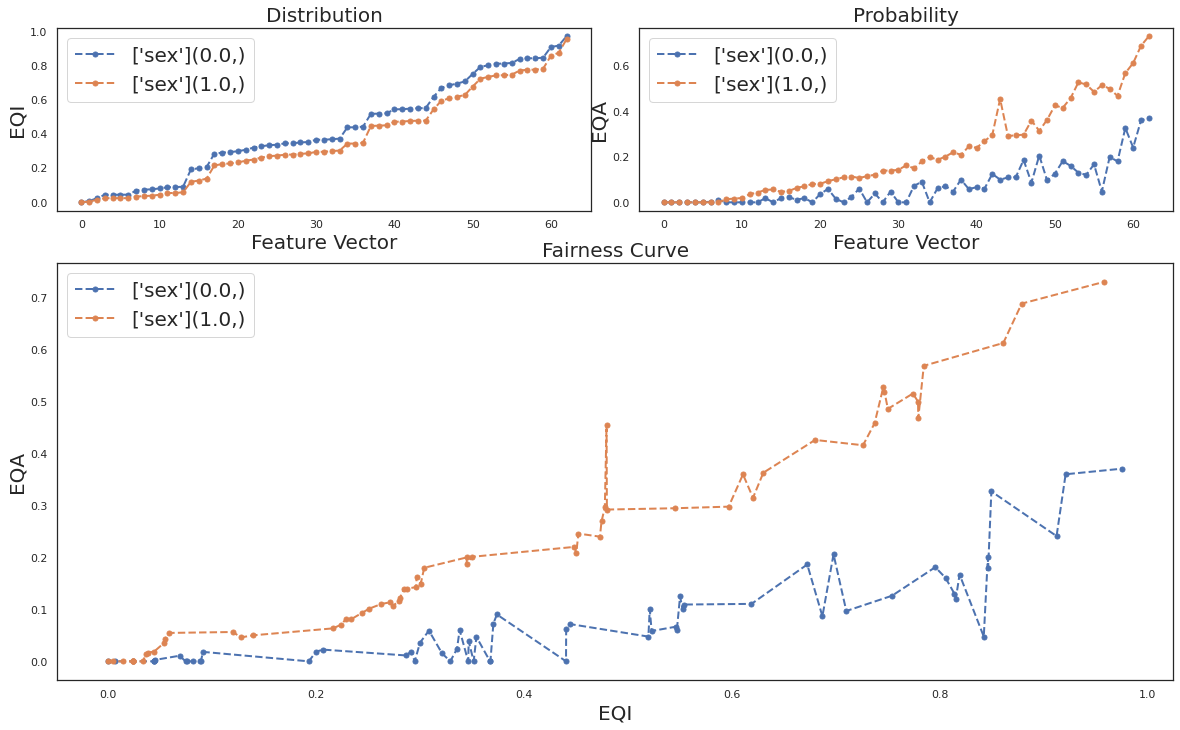

In [194]:
df_f,datos_f = flai_dataset.fairness_eqa_eqi(features = ['education','age'], 
                              target_column = 'proba', 
                              column_filter = ['sex'],
                              plot = True)

In [131]:
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_adult
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.lfr import LFR

In [132]:
## import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2


if dataset_used == "adult":
#     dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
    
elif dataset_used == "german":
#     dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
np.random.seed(1)

In [133]:
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [84]:
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

In [85]:
optim_options = {
    "distortion_fun": get_distortion_adult,
    "epsilon": 0.05,
    "clist": [0.99, 1.99, 2.99],
    "dlist": [.1, 0.05, 0]
}
    
OP = OptimPreproc(OptTools, optim_options)

OP = OP.fit(dataset_orig_train)
dataset_transf_train = OP.transform(dataset_orig_train, transform_Y=True)

dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)

dataset_transf_test = OP.transform(dataset_orig_test, transform_Y = True)
dataset_transf_test = dataset_orig_test.align_datasets(dataset_transf_test)


Optimized Preprocessing: Objective converged to 0.010890


                age  education       sex      race     label
age        1.000000   0.026878  0.087111  0.027662  0.228793
education  0.026878   1.000000 -0.001475  0.034768  0.317179
sex        0.087111  -0.001475  1.000000  0.134281  0.058479
race       0.027662   0.034768  0.134281  1.000000  0.046588
label      0.228793   0.317179  0.058479  0.046588  1.000000


<AxesSubplot: >

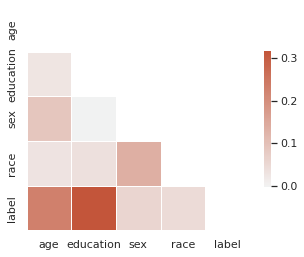

In [86]:
import seaborn as sns
sns.set_theme(style="white")

# Generate a large random dataset
df_train_transf = pd.DataFrame(dataset_transf_train.features,columns = dataset_transf_train.feature_names)

df_train_transf['label'] = dataset_transf_train.labels
df_train_transf['age'] = df_train_transf.apply(lambda row: 0 if row['Age (decade)=10'] == 1 
                            else 1 if row['Age (decade)=20'] == 1 
                            else 2 if row['Age (decade)=30'] == 1
                            else 3 if row['Age (decade)=40'] == 1
                            else 4 if row['Age (decade)=50'] == 1
                            else 5 if row['Age (decade)=60'] == 1
                            else 6 if row['Age (decade)=>=70'] == 1
                            else None,axis = 1)
df_train_transf['education'] = df_train_transf.apply(lambda row: 0 if row['Education Years=<6'] == 1 
                                  else 1 if row['Education Years=6'] == 1 
                                  else 2 if row['Education Years=7'] == 1 
                                  else 3 if row['Education Years=8'] == 1 
                                  else 4 if row['Education Years=9'] == 1 
                                  else 5 if row['Education Years=10'] == 1 
                                  else 6 if row['Education Years=11'] == 1 
                                  else 7 if row['Education Years=12'] == 1
                                  else 8 if row['Education Years=>12'] == 1  
                                  else None,axis = 1)
df_train_transf = df_train_transf[['age','education','sex','race','label']]
# Compute the correlation matrix
corr = df_train_transf.corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [87]:
model_op = XGBClassifier()
model_op.fit(df_train_transf[['sex', 'race', 'age','education']], df_train_transf['label'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [88]:
df_test = pd.DataFrame(dataset_transf_test.features,columns = dataset_transf_test.feature_names)

df_test['label'] = dataset_transf_test.labels
df_test['age'] = df_test.apply(lambda row: 0 if row['Age (decade)=10'] == 1 
                            else 1 if row['Age (decade)=20'] == 1 
                            else 2 if row['Age (decade)=30'] == 1
                            else 3 if row['Age (decade)=40'] == 1
                            else 4 if row['Age (decade)=50'] == 1
                            else 5 if row['Age (decade)=60'] == 1
                            else 6 if row['Age (decade)=>=70'] == 1
                            else None,axis = 1)
df_test['education'] = df_test.apply(lambda row: 0 if row['Education Years=<6'] == 1 
                                  else 1 if row['Education Years=6'] == 1 
                                  else 2 if row['Education Years=7'] == 1 
                                  else 3 if row['Education Years=8'] == 1 
                                  else 4 if row['Education Years=9'] == 1 
                                  else 5 if row['Education Years=10'] == 1 
                                  else 6 if row['Education Years=11'] == 1 
                                  else 7 if row['Education Years=12'] == 1
                                  else 8 if row['Education Years=>12'] == 1  
                                  else None,axis = 1)
df_test = df_test[['age','education','sex','race','label']]

In [93]:
df_test['Predicted'] = model_op.predict(df_test[['sex', 'race', 'age','education']])
df_test['proba'] = model_op.predict_proba(df_test[['sex', 'race', 'age','education']])[:,1]


In [95]:
op_dataset = data.Data(df_test, transform=False)

metrics_xgboost_mitigated_fair_data = op_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_op,df_fairness_op = op_dataset.get_df_metrics(metrics_xgboost_mitigated_fair_data)

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


In [96]:
df_performance_op

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.782365,9815.0,1111.0,2078.0,1649.0,0.442447,0.101684,0.557553,0.188357
sex_privileged,0.768169,6345.0,761.0,1507.0,1170.0,0.437056,0.107093,0.562944,0.197383
sex_unprivileged,0.810883,3470.0,350.0,571.0,479.0,0.456190,0.091623,0.543810,0.170226
race_privileged,0.774300,8080.0,1035.0,1763.0,1519.0,0.462828,0.113549,0.537172,0.206018
race_unprivileged,0.826684,1735.0,76.0,315.0,130.0,0.292135,0.041966,0.707865,0.091312


In [97]:
df_fairness_op

,EOD,DI,SPD,OD
sex_fair_metrics,0.019134,0.862413,-0.027157,0.003665
race_fair_metrics,-0.170693,0.443225,-0.114706,-0.242276


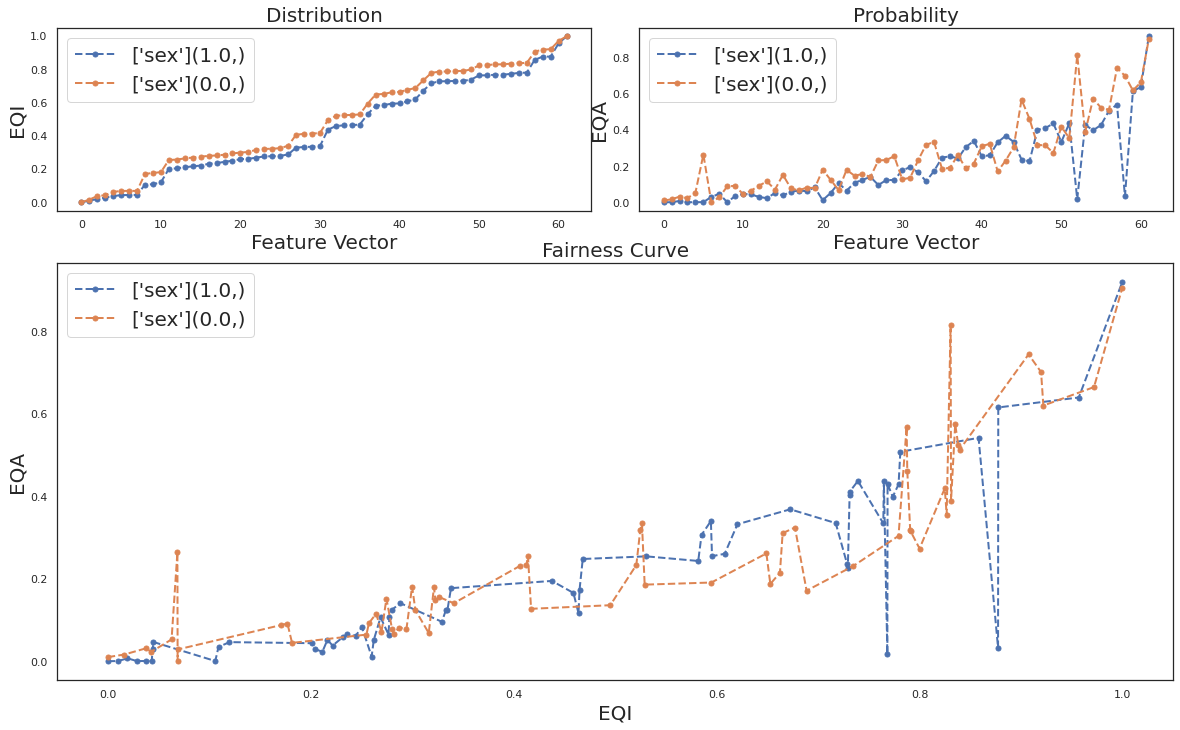

,group,reference,EQI,EQA,F
1,"['sex'](0.0,)","['sex'](1.0,)",-0.05,-0.06,0.08


In [99]:
df_f,datos_f = op_dataset.fairness_eqa_eqi(features = ['education','age'], 
                              target_column = 'proba', 
                              column_filter = ['sex'],
                              plot = True)
df_f

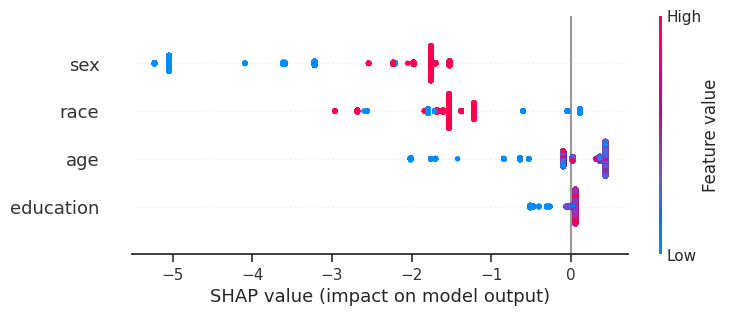

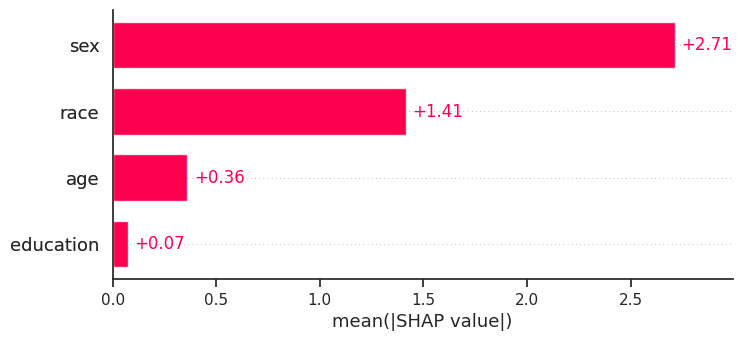

In [200]:
explainer_op = shap.Explainer(model_op)
shap_values_op = explainer_op(df_test[['age','education','sex','race']])
shap.plots.beeswarm(shap_values_op)
shap.plots.bar(shap_values_op)

In [159]:
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [160]:
unprivileged_groups

[{'sex': 0}]

In [161]:

RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [162]:
dataset_transf_train.instance_weights

array([0.85425278, 0.78843553, 1.09212307, ..., 1.09212307, 0.85425278,
       1.09212307])

In [165]:
df_train_transf

,age,education,sex,race,label
0,2,4,1.090119,0.0,0.0
1,1,4,1.090119,0.0,0.0
2,2,8,0.790634,1.0,1.0
3,1,8,1.090119,1.0,0.0
4,2,8,1.090119,1.0,0.0
...,...,...,...,...,...
34184,3,8,1.090119,1.0,0.0
34185,3,4,1.090119,1.0,0.0
34186,4,0,1.090119,0.0,0.0
34187,6,8,1.090119,1.0,0.0


                age  education       sex      race     label
age        1.000000   0.030411  0.089602  0.032044  0.229447
education  0.030411   1.000000  0.005537  0.048840  0.321561
sex        0.089602   0.005537  1.000000  0.096592  0.213966
race       0.032044   0.048840  0.096592  1.000000  0.081143
label      0.229447   0.321561  0.213966  0.081143  1.000000


<AxesSubplot: >

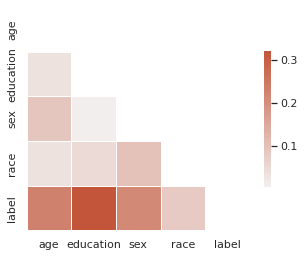

In [166]:
import seaborn as sns
import pandas as pd
sns.set_theme(style="white")

# Generate a large random dataset
df_train_transf = pd.DataFrame(dataset_transf_train.features,columns = dataset_transf_train.feature_names)

df_train_transf['label'] = dataset_transf_train.labels
df_train_transf['age'] = df_train_transf.apply(lambda row: 0 if row['Age (decade)=10'] == 1 
                            else 1 if row['Age (decade)=20'] == 1 
                            else 2 if row['Age (decade)=30'] == 1
                            else 3 if row['Age (decade)=40'] == 1
                            else 4 if row['Age (decade)=50'] == 1
                            else 5 if row['Age (decade)=60'] == 1
                            else 6 if row['Age (decade)=>=70'] == 1
                            else None,axis = 1)
df_train_transf['education'] = df_train_transf.apply(lambda row: 0 if row['Education Years=<6'] == 1 
                                  else 1 if row['Education Years=6'] == 1 
                                  else 2 if row['Education Years=7'] == 1 
                                  else 3 if row['Education Years=8'] == 1 
                                  else 4 if row['Education Years=9'] == 1 
                                  else 5 if row['Education Years=10'] == 1 
                                  else 6 if row['Education Years=11'] == 1 
                                  else 7 if row['Education Years=12'] == 1
                                  else 8 if row['Education Years=>12'] == 1  
                                  else None,axis = 1)

df_train_transf = df_train_transf[['age','education','sex','race','label']]
#df_train_transf['age'] = dataset_transf_train.instance_weights * df_train_transf['age']
#df_train_transf['education'] = dataset_transf_train.instance_weights * df_train_transf['education']
#df_train_transf['sex'] = dataset_transf_train.instance_weights * df_train_transf['sex']
#df_train_transf['sex'] = dataset_transf_train.instance_weights * df_train_transf['sex']
#df_train_transf['age'] = dataset_transf_train.instance_weights * df_train_transf['age']

# Compute the correlation matrix
corr = df_train_transf.corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [167]:
model_rw = XGBClassifier()
model_rw.fit(df_train_transf[['sex', 'race', 'age','education']], df_train_transf['label'],sample_weight = dataset_transf_train.instance_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [168]:
df_test = pd.DataFrame(dataset_orig_test.features,columns = dataset_orig_test.feature_names)

df_test['label'] = dataset_orig_test.labels
df_test['age'] = df_test.apply(lambda row: 0 if row['Age (decade)=10'] == 1 
                            else 1 if row['Age (decade)=20'] == 1 
                            else 2 if row['Age (decade)=30'] == 1
                            else 3 if row['Age (decade)=40'] == 1
                            else 4 if row['Age (decade)=50'] == 1
                            else 5 if row['Age (decade)=60'] == 1
                            else 6 if row['Age (decade)=>=70'] == 1
                            else None,axis = 1)
df_test['education'] = df_test.apply(lambda row: 0 if row['Education Years=<6'] == 1 
                                  else 1 if row['Education Years=6'] == 1 
                                  else 2 if row['Education Years=7'] == 1 
                                  else 3 if row['Education Years=8'] == 1 
                                  else 4 if row['Education Years=9'] == 1 
                                  else 5 if row['Education Years=10'] == 1 
                                  else 6 if row['Education Years=11'] == 1 
                                  else 7 if row['Education Years=12'] == 1
                                  else 8 if row['Education Years=>12'] == 1  
                                  else None,axis = 1)
df_test = df_test[['age','education','sex','race','label']]

In [169]:
df_test['Predicted'] = model_rw.predict(df_test[['sex', 'race', 'age','education']])
df_test['proba'] = model_rw.predict_proba(df_test[['sex', 'race', 'age','education']])[:,1]


In [170]:
rw_dataset = data.Data(df_test, transform=False)

metrics_xgboost_mitigated_fair_data = rw_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_op,df_fairness_op = rw_dataset.get_df_metrics(metrics_xgboost_mitigated_fair_data)

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


In [171]:
df_performance_op

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.789053,10027.0,1116.0,1975.0,1535.0,0.437322,0.100153,0.562678,0.180919
sex_privileged,0.757982,6085.0,709.0,1656.0,1322.0,0.443922,0.104357,0.556078,0.207839
sex_unprivileged,0.851260,3942.0,407.0,319.0,213.0,0.400376,0.093585,0.599624,0.127023
race_privileged,0.778826,8284.0,1028.0,1738.0,1456.0,0.455855,0.110395,0.544145,0.198625
race_unprivileged,0.848626,1743.0,88.0,237.0,79.0,0.250000,0.048061,0.750000,0.077783


In [172]:
df_fairness_op

,EOD,DI,SPD,OD
sex_fair_metrics,-0.043546,0.611162,-0.080816,-0.054318
race_fair_metrics,-0.205855,0.391608,-0.120842,-0.268189


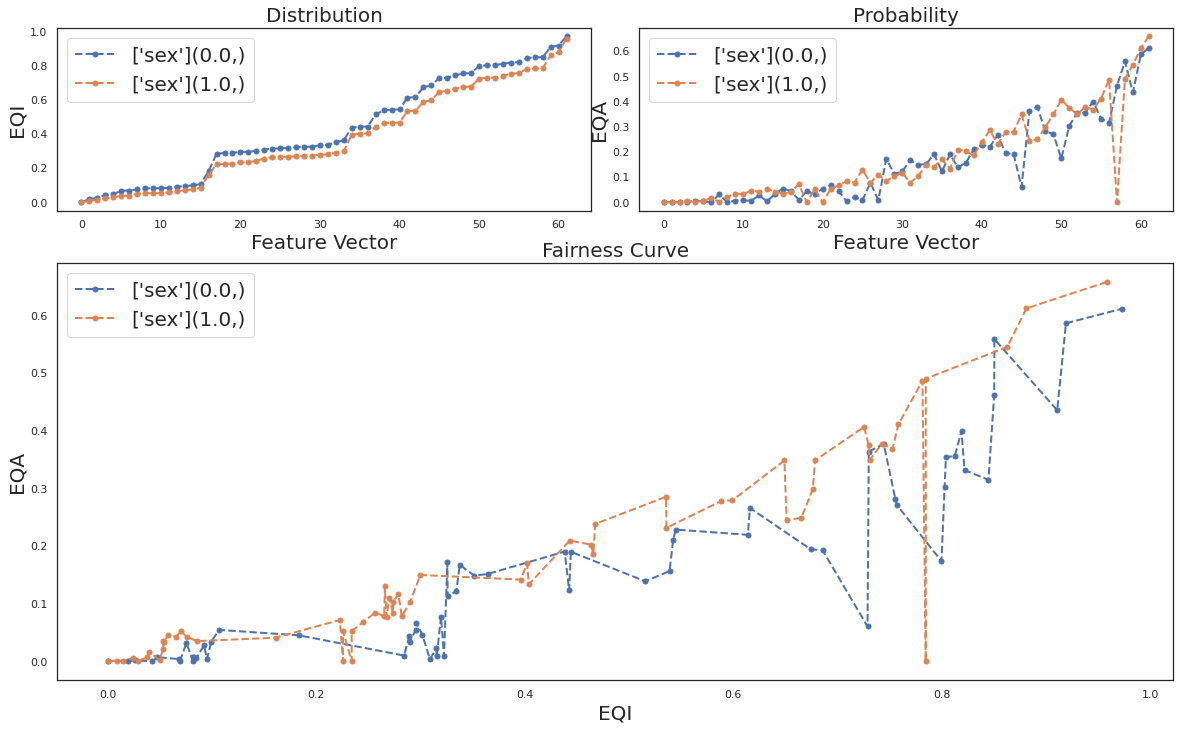

,group,reference,EQI,EQA,F
0,"['sex'](0.0,)","['sex'](1.0,)",-0.05,0.01,0.05


In [173]:
df_f,datos_f = rw_dataset.fairness_eqa_eqi(features = ['education','age'], 
                              target_column = 'proba', 
                              column_filter = ['sex'],
                              plot = True)
df_f

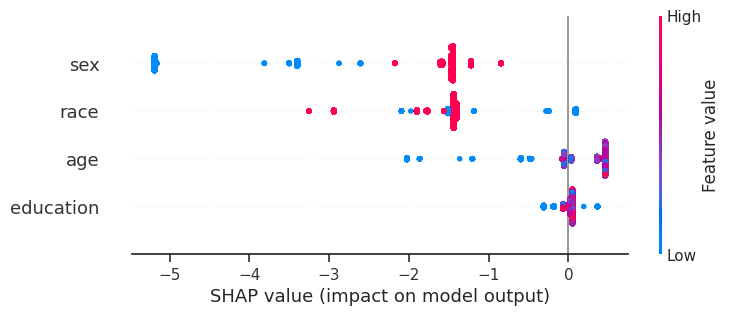

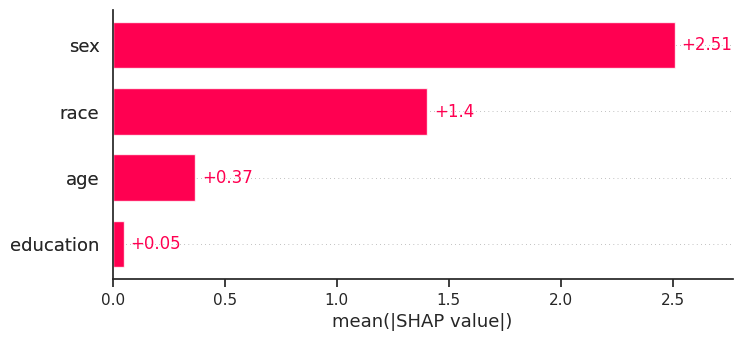

In [211]:
explainer_rw = shap.Explainer(model_rw)
shap_values_rw = explainer_rw(df_test[['age','education','sex','race']])
shap.plots.beeswarm(shap_values_rw)
shap.plots.bar(shap_values_rw)

In [195]:
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

                age  education       sex      race     label
age        1.000000   0.022899  0.086368  0.028689  0.225544
education  0.022899   1.000000  0.007845  0.048149  0.318799
sex        0.086368   0.007845  1.000000  0.099183  0.215802
race       0.028689   0.048149  0.099183  1.000000  0.083798
label      0.225544   0.318799  0.215802  0.083798  1.000000


<AxesSubplot: >

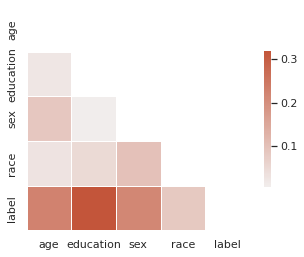

In [196]:
import seaborn as sns
sns.set_theme(style="white")

# Generate a large random dataset
df_train_transf = pd.DataFrame(dataset_orig_train.features,columns = dataset_orig_train.feature_names)

df_train_transf['label'] = dataset_orig_train.labels

df_train_transf['age'] = df_train_transf.apply(lambda row: 0 if row['Age (decade)=10'] == 1 
                            else 1 if row['Age (decade)=20'] == 1 
                            else 2 if row['Age (decade)=30'] == 1
                            else 3 if row['Age (decade)=40'] == 1
                            else 4 if row['Age (decade)=50'] == 1
                            else 5 if row['Age (decade)=60'] == 1
                            else 6 if row['Age (decade)=>=70'] == 1
                            else None,axis = 1)
df_train_transf['education'] = df_train_transf.apply(lambda row: 0 if row['Education Years=<6'] == 1 
                                  else 1 if row['Education Years=6'] == 1 
                                  else 2 if row['Education Years=7'] == 1 
                                  else 3 if row['Education Years=8'] == 1 
                                  else 4 if row['Education Years=9'] == 1 
                                  else 5 if row['Education Years=10'] == 1 
                                  else 6 if row['Education Years=11'] == 1 
                                  else 7 if row['Education Years=12'] == 1
                                  else 8 if row['Education Years=>12'] == 1  
                                  else None,axis = 1)
df_train_transf = df_train_transf[['age','education','sex','race','label']]

# Compute the correlation matrix
corr = df_train_transf.corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [197]:
dataset_orig_train.feature_names

['race',
 'sex',
 'Age (decade)=10',
 'Age (decade)=20',
 'Age (decade)=30',
 'Age (decade)=40',
 'Age (decade)=50',
 'Age (decade)=60',
 'Age (decade)=>=70',
 'Education Years=6',
 'Education Years=7',
 'Education Years=8',
 'Education Years=9',
 'Education Years=10',
 'Education Years=11',
 'Education Years=12',
 'Education Years=<6',
 'Education Years=>12']

In [198]:
TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1
        )
dataset_orig_train.features = df_train_transf[['age','education','sex','race']].values
dataset_orig_train.feature_names = ['age','education','sex','race']

TR = TR.fit(dataset_orig_train)

step: 0, loss: 2.2351769601161195, L_x: 14.736558208486404,  L_y: 0.7508464256801041,  L_z: 0.005337356793687439
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           50     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23518D+00    |proj g|=  1.65168D-01

At iterate    1    f=  2.07357D+00    |proj g|=  1.16633D-01

At iterate    2    f=  1.88992D+00    |proj g|=  1.14733D-01

At iterate    3    f=  1.64469D+00    |proj g|=  2.13965D-01
  ys=-5.418E-02  -gs= 2.268E-01 BFGS update SKIPPED
step: 250, loss: 1.2698928576432305, L_x: 7.298942098315477,  L_y: 0.5313230585686081,  L_z: 0.004337794621537362

At iterate    4    f=  1.26989D+00    |proj g|=  2.06996D-01

At iterate    5    f=  9.68861D-01    |proj g|=  6.71908D-01

At iterate    6    f=  7.36911D-01    |proj g|=  1.49258D-01

At iterate    7    f=  7.24796D-01    |proj g|=  2.11603D-02
step: 500, loss: 0.7202099908971548, L_x: 2.15299072877045

In [199]:
df_test = pd.DataFrame(dataset_orig_test.features,columns = dataset_orig_test.feature_names)

df_test['label'] = dataset_orig_test.labels
df_test['age'] = df_test.apply(lambda row: 0 if row['Age (decade)=10'] == 1 
                            else 1 if row['Age (decade)=20'] == 1 
                            else 2 if row['Age (decade)=30'] == 1
                            else 3 if row['Age (decade)=40'] == 1
                            else 4 if row['Age (decade)=50'] == 1
                            else 5 if row['Age (decade)=60'] == 1
                            else 6 if row['Age (decade)=>=70'] == 1
                            else None,axis = 1)
df_test['education'] = df_test.apply(lambda row: 0 if row['Education Years=<6'] == 1 
                                  else 1 if row['Education Years=6'] == 1 
                                  else 2 if row['Education Years=7'] == 1 
                                  else 3 if row['Education Years=8'] == 1 
                                  else 4 if row['Education Years=9'] == 1 
                                  else 5 if row['Education Years=10'] == 1 
                                  else 6 if row['Education Years=11'] == 1 
                                  else 7 if row['Education Years=12'] == 1
                                  else 8 if row['Education Years=>12'] == 1  
                                  else None,axis = 1)
df_test = df_test[['age','education','sex','race','label']]
dataset_orig_test.features = df_test[['age','education','sex','race']].values
dataset_orig_test.feature_names = ['age','education','sex','race']


In [200]:
# Transform training data and align features
dataset_transf_train = TR.transform(dataset_orig_train)
dataset_transf_test = TR.transform(dataset_orig_test)

                age  education       sex      race     label
age        1.000000   0.017902 -0.897330  0.132224  0.206554
education  0.017902   1.000000  0.239173  0.122191  0.536578
sex       -0.897330   0.239173  1.000000 -0.067200 -0.242579
race       0.132224   0.122191 -0.067200  1.000000  0.138111
label      0.206554   0.536578 -0.242579  0.138111  1.000000


<AxesSubplot: >

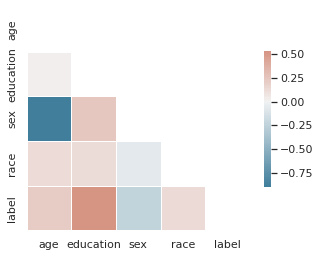

In [201]:
import seaborn as sns
sns.set_theme(style="white")

# Generate a large random dataset
df_train_transf = pd.DataFrame(dataset_transf_train.features,columns = dataset_transf_train.feature_names)

df_train_transf['label'] = dataset_transf_train.labels
'''
df_train_transf['age'] = df_train_transf.apply(lambda row: 0 if row['Age (decade)=10'] == 1 
                            else 1 if row['Age (decade)=20'] == 1 
                            else 2 if row['Age (decade)=30'] == 1
                            else 3 if row['Age (decade)=40'] == 1
                            else 4 if row['Age (decade)=50'] == 1
                            else 5 if row['Age (decade)=60'] == 1
                            else 6 if row['Age (decade)=>=70'] == 1
                            else None,axis = 1)
df_train_transf['education'] = df_train_transf.apply(lambda row: 0 if row['Education Years=<6'] == 1 
                                  else 1 if row['Education Years=6'] == 1 
                                  else 2 if row['Education Years=7'] == 1 
                                  else 3 if row['Education Years=8'] == 1 
                                  else 4 if row['Education Years=9'] == 1 
                                  else 5 if row['Education Years=10'] == 1 
                                  else 6 if row['Education Years=11'] == 1 
                                  else 7 if row['Education Years=12'] == 1
                                  else 8 if row['Education Years=>12'] == 1  
                                  else None,axis = 1)
'''
df_train_transf = df_train_transf[['age','education','sex','race','label']]

# Compute the correlation matrix
corr = df_train_transf.corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [202]:
df_test = pd.DataFrame(dataset_orig_test.features,columns = dataset_orig_test.feature_names)

df_test['label'] = dataset_orig_test.labels

df_test = df_test[['age','education','sex','race','label']]
dataset_orig_test.features = df_test[['age','education','sex','race']].values
dataset_orig_test.feature_names = ['age','education','sex','race']

In [203]:
model_lfr = XGBClassifier()
model_lfr.fit(dataset_transf_train.features, dataset_transf_train.labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [204]:
df_test['Predicted'] = model_lfr.predict(dataset_transf_test.features)
df_test['proba'] = model_lfr.predict_proba(dataset_transf_test.features)[:,1]

In [205]:
lfr_dataset = data.Data(df_test, transform=False)

metrics_xgboost_mitigated_fair_data = lfr_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_op,df_fairness_op = lfr_dataset.get_df_metrics(metrics_xgboost_mitigated_fair_data)

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


In [206]:
df_performance_op

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.782229,10278.0,818.0,2373.0,1184.0,0.332865,0.073720,0.667135,0.136627
sex_privileged,0.748294,6391.0,417.0,2054.0,955.0,0.317381,0.061251,0.682619,0.139758
sex_unprivileged,0.851117,3887.0,401.0,319.0,229.0,0.417883,0.093517,0.582117,0.130273
race_privileged,0.770631,8601.0,741.0,2144.0,1092.0,0.337454,0.079319,0.662546,0.145731
race_unprivileged,0.852530,1677.0,77.0,229.0,92.0,0.286604,0.043900,0.713396,0.081446


In [207]:
df_fairness_op

,EOD,DI,SPD,OD
sex_fair_metrics,0.100502,0.932135,-0.009485,0.132767
race_fair_metrics,-0.050849,0.558879,-0.064285,-0.086269


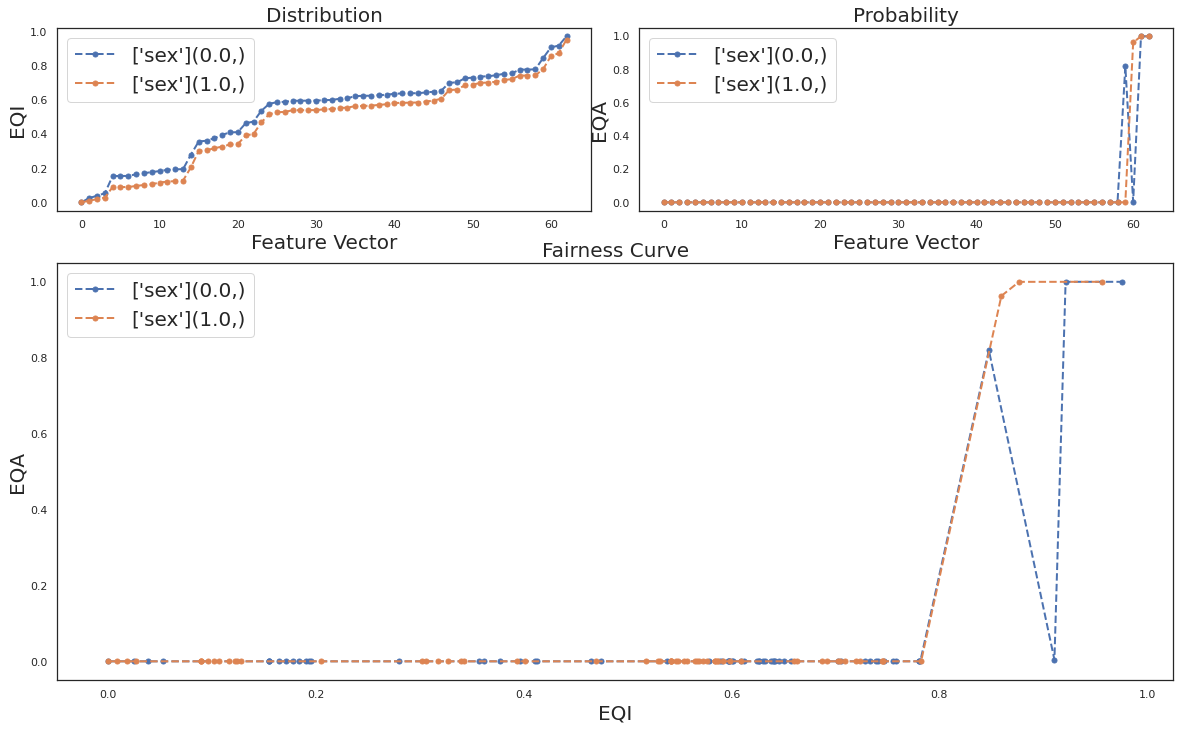

,group,reference,EQI,EQA,F
1,"['sex'](1.0,)","['sex'](0.0,)",0.05,-0.0,0.05


In [208]:
df_f,datos_f = lfr_dataset.fairness_eqa_eqi(features = ['education','age'], 
                              target_column = 'proba', 
                              column_filter = ['sex'],
                              plot = True)
df_f

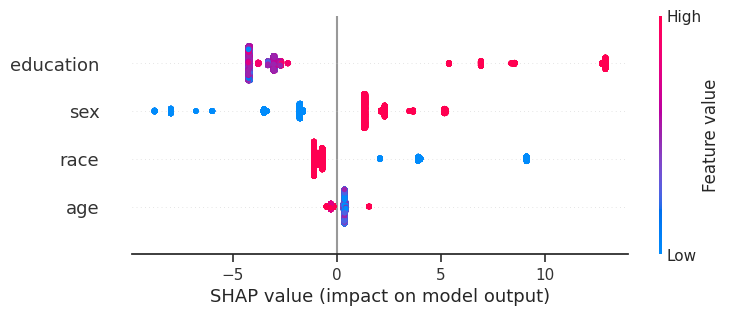

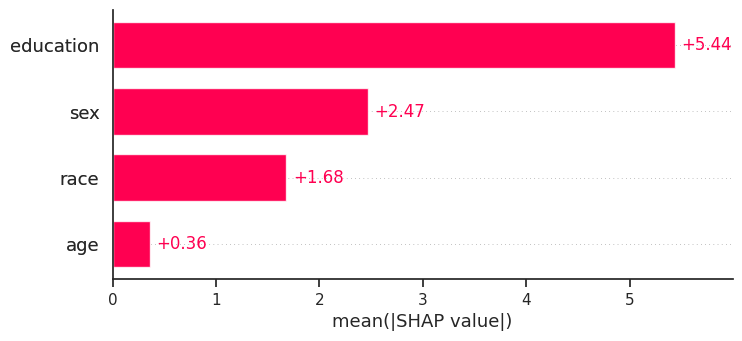

In [225]:
explainer_lfr = shap.Explainer(model_lfr)
shap_values_lfr = explainer_lfr(df_test[['age','education','sex','race']])
shap.plots.beeswarm(shap_values_lfr)
shap.plots.bar(shap_values_lfr)

In [209]:
from dalex.fairness import resample
import dalex as dx

In [210]:
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

                age  education       sex      race     label
age        1.000000   0.025638  0.089041  0.034331  0.227603
education  0.025638   1.000000  0.007162  0.051952  0.315099
sex        0.089041   0.007162  1.000000  0.103252  0.215772
race       0.034331   0.051952  0.103252  1.000000  0.086802
label      0.227603   0.315099  0.215772  0.086802  1.000000


<AxesSubplot: >

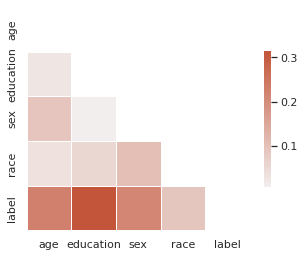

In [211]:
import seaborn as sns
sns.set_theme(style="white")

# Generate a large random dataset
df_train_transf = pd.DataFrame(dataset_orig_train.features,columns = dataset_orig_train.feature_names)

df_train_transf['label'] = dataset_orig_train.labels

df_train_transf['age'] = df_train_transf.apply(lambda row: 0 if row['Age (decade)=10'] == 1 
                            else 1 if row['Age (decade)=20'] == 1 
                            else 2 if row['Age (decade)=30'] == 1
                            else 3 if row['Age (decade)=40'] == 1
                            else 4 if row['Age (decade)=50'] == 1
                            else 5 if row['Age (decade)=60'] == 1
                            else 6 if row['Age (decade)=>=70'] == 1
                            else None,axis = 1)
df_train_transf['education'] = df_train_transf.apply(lambda row: 0 if row['Education Years=<6'] == 1 
                                  else 1 if row['Education Years=6'] == 1 
                                  else 2 if row['Education Years=7'] == 1 
                                  else 3 if row['Education Years=8'] == 1 
                                  else 4 if row['Education Years=9'] == 1 
                                  else 5 if row['Education Years=10'] == 1 
                                  else 6 if row['Education Years=11'] == 1 
                                  else 7 if row['Education Years=12'] == 1
                                  else 8 if row['Education Years=>12'] == 1  
                                  else None,axis = 1)
df_train_transf = df_train_transf[['age','education','sex','race','label']]

# Compute the correlation matrix
corr = df_train_transf.corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [212]:
indices_uniform = resample(df_train_transf.sex, df_train_transf.label, verbose = False)


In [213]:
len(np.unique(indices_uniform))

31219

In [214]:
len(df_train_transf)

34189

In [215]:
len( df_train_transf.iloc[indices_uniform])

34189

                age  education       sex      race     label
age        1.000000   0.023202  0.047706  0.030740  0.215421
education  0.023202   1.000000 -0.059968  0.049172  0.324541
sex        0.047706  -0.059968  1.000000  0.085223  0.000049
race       0.030740   0.049172  0.085223  1.000000  0.075194
label      0.215421   0.324541  0.000049  0.075194  1.000000


<AxesSubplot: >

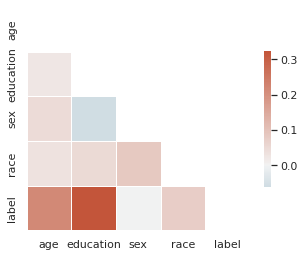

In [216]:
# Compute the correlation matrix
corr = df_train_transf.iloc[indices_uniform].corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

                age  education       sex      race     label
age        1.000000   0.025638  0.089041  0.034331  0.227603
education  0.025638   1.000000  0.007162  0.051952  0.315099
sex        0.089041   0.007162  1.000000  0.103252  0.215772
race       0.034331   0.051952  0.103252  1.000000  0.086802
label      0.227603   0.315099  0.215772  0.086802  1.000000


<AxesSubplot: >

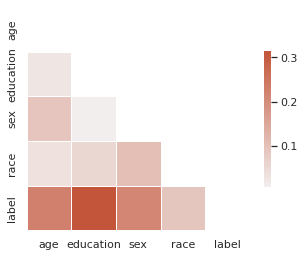

In [217]:
# Compute the correlation matrix
corr = df_train_transf.corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [218]:
model_resample = XGBClassifier()
model_resample.fit(df_train_transf[['age','education','sex','race']].values[indices_uniform], df_train_transf['label'][indices_uniform])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [219]:
df_test = pd.DataFrame(dataset_orig_test.features,columns = dataset_orig_test.feature_names)

df_test['label'] = dataset_orig_test.labels
df_test['age'] = df_test.apply(lambda row: 0 if row['Age (decade)=10'] == 1 
                            else 1 if row['Age (decade)=20'] == 1 
                            else 2 if row['Age (decade)=30'] == 1
                            else 3 if row['Age (decade)=40'] == 1
                            else 4 if row['Age (decade)=50'] == 1
                            else 5 if row['Age (decade)=60'] == 1
                            else 6 if row['Age (decade)=>=70'] == 1
                            else None,axis = 1)
df_test['education'] = df_test.apply(lambda row: 0 if row['Education Years=<6'] == 1 
                                  else 1 if row['Education Years=6'] == 1 
                                  else 2 if row['Education Years=7'] == 1 
                                  else 3 if row['Education Years=8'] == 1 
                                  else 4 if row['Education Years=9'] == 1 
                                  else 5 if row['Education Years=10'] == 1 
                                  else 6 if row['Education Years=11'] == 1 
                                  else 7 if row['Education Years=12'] == 1
                                  else 8 if row['Education Years=>12'] == 1  
                                  else None,axis = 1)
df_test = df_test[['age','education','sex','race','label']]

In [220]:
df_test['Predicted'] = model_resample.predict(df_test[['age','education','sex','race']])
df_test['proba'] = model_resample.predict_proba(df_test[['age','education','sex','race']])[:,1]

In [221]:
resample_dataset = data.Data(df_test, transform=False)

metrics_xgboost_mitigated_fair_data = resample_dataset.fairness_metrics(target_column='label', predicted_column = 'Predicted',
                            columns_fair = {'sex' : {'privileged' : 1, 'unprivileged' : 0},
                                            'race' : {'privileged' : 1, 'unprivileged' : 0}})
df_performance_op,df_fairness_op = resample_dataset.get_df_metrics(metrics_xgboost_mitigated_fair_data)

Calculating metrics for : sex  the value :  1
Calculating metrics for : sex  the value :  0
Calculating metrics for : race  the value :  1
Calculating metrics for : race  the value :  0


In [222]:
df_performance_op

,ACC,TN,FP,FN,TP,TPR,FPR,FNR,PPP
model,0.784345,10317.0,844.0,2316.0,1176.0,0.336770,0.075620,0.663230,0.137856
sex_privileged,0.752151,6495.0,411.0,2038.0,937.0,0.314958,0.059513,0.685042,0.136423
sex_unprivileged,0.851006,3822.0,433.0,278.0,239.0,0.462282,0.101763,0.537718,0.140821
race_privileged,0.774117,8644.0,759.0,2079.0,1082.0,0.342297,0.080719,0.657703,0.146530
race_unprivileged,0.845859,1673.0,85.0,237.0,94.0,0.283988,0.048350,0.716012,0.085687


In [223]:
df_fairness_op

,EOD,DI,SPD,OD
sex_fair_metrics,0.147324,1.032238,0.004398,0.189574
race_fair_metrics,-0.058309,0.584775,-0.060843,-0.090677


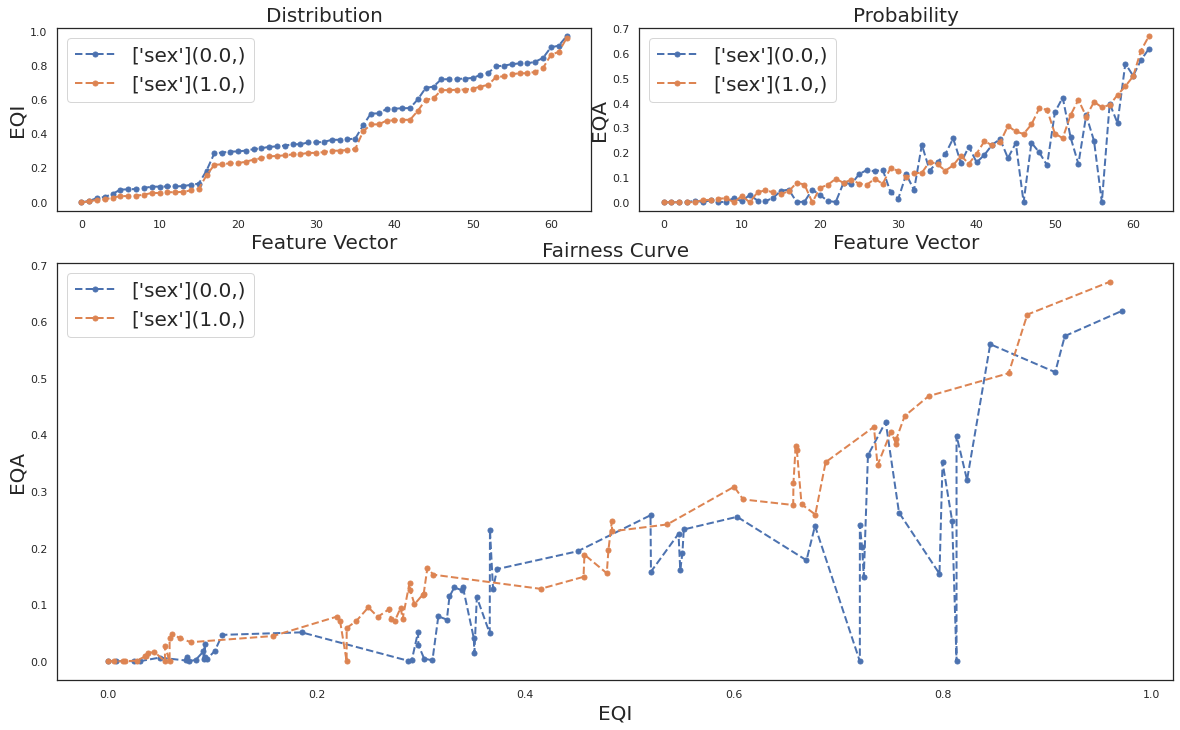

,group,reference,EQI,EQA,F
0,"['sex'](0.0,)","['sex'](1.0,)",-0.05,0.03,0.06


In [225]:
df_f,datos_f = resample_dataset.fairness_eqa_eqi(features = ['education','age'], 
                              target_column = 'proba', 
                              column_filter = ['sex'],
                              plot = True)
df_f

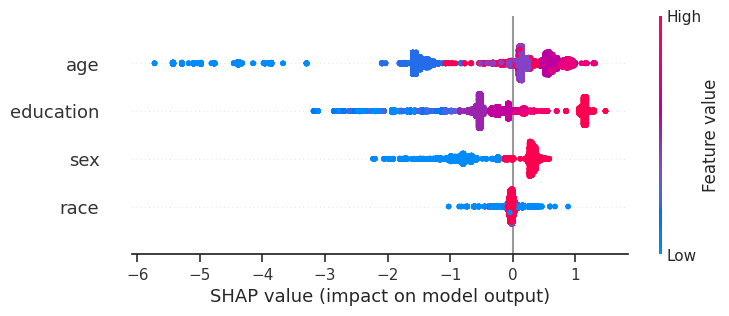

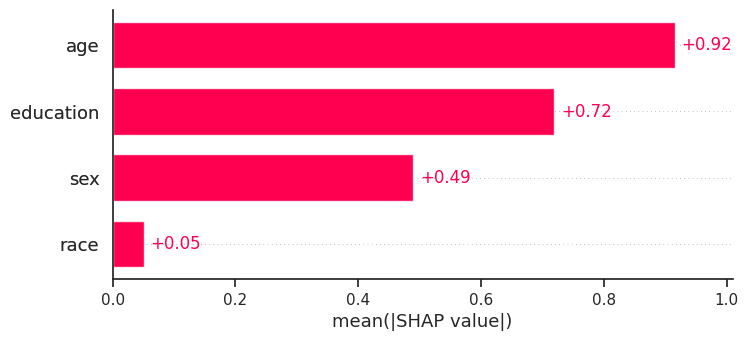

In [236]:
explainer_resample = shap.Explainer(model_resample)
shap_values_resample = explainer_resample(df_test[['age','education','sex','race']])
shap.plots.beeswarm(shap_values_resample)
shap.plots.bar(shap_values_resample)